In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d kasikrit/308-456-dogs-vs-cats-dataset

 98% 534M/546M [00:13<00:00, 136MB/s]
100% 546M/546M [00:13<00:00, 42.1MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/308-456-dogs-vs-cats-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
input_shape = (150, 150, 3)
img_width = 150
img_height = 150
batch_size = 32
train_data = '/content/dataset_dogs_vs_cats/train'
validation_data = '/content/dataset_dogs_vs_cats/valid'


In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 18697 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No need to shuffle validation data
)

Found 6303 images belonging to 2 classes.


In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs("/content/Colab_Notebooks/", exist_ok=True)


In [ ]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/Colab_Notebooks/model_checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)

In [ ]:
# Fit the model
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    callbacks=[checkpoint, earlystop, reduce_lr],
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/50
585/585 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5895
Epoch 1: val_loss improved from inf to 0.59101, saving model to /content/Colab_Notebooks/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


585/585 [==============================] - 143s 234ms/step - loss: 0.6833 - accuracy: 0.5895 - val_loss: 0.5910 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 2/50
585/585 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.6719
Epoch 2: val_loss improved from 0.59101 to 0.51444, saving model to /content/Colab_Notebooks/model_checkpoint.h5
585/585 [==============================] - 137s 235ms/step - loss: 0.6055 - accuracy: 0.6719 - val_loss: 0.5144 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 3/50
585/585 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7072
Epoch 3: val_loss improved from 0.51444 to 0.51023, saving model to /content/Colab_Notebooks/model_checkpoint.h5
585/585 [==============================] - 137s 234ms/step - loss: 0.5701 - accuracy: 0.7072 - val_loss: 0.5102 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 4/50
585/585 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.7263
Epoch 4: val_loss improved from 0.51023 to

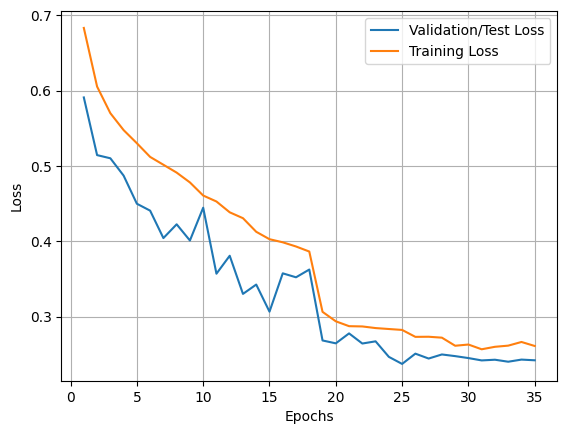

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

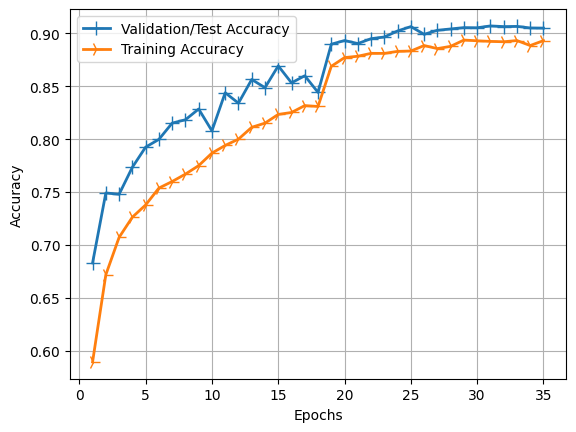

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

(1, 150, 150, 3)
1/1 [==============================] - 0s 79ms/step
[[0.04582993]]
[[0.04582993]]
this is cat


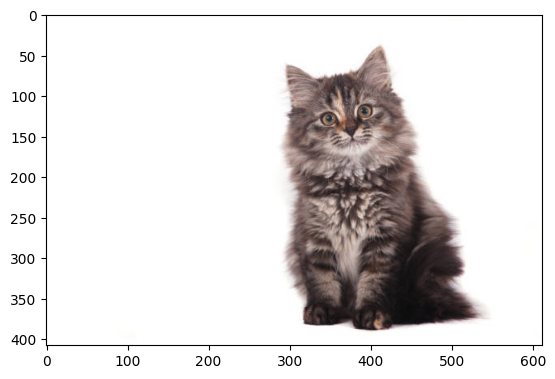

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

image_path = '/content/istockphoto-1306857294-612x612.jpg'
model = models.load_model('/content/Colab_Notebooks/model_checkpoint.h5')
test_image = load_img(image_path,target_size = (150,150,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
print(test_image.shape)
result = model.predict(test_image)
print(result)
print(result)
if result[0][0] == 1:
  print("This is dog")
else:
  print("this is cat")
  # reading the image
testImage = img.imread(image_path)

# displaying the modified image
plt.imshow(testImage)

In [ ]:
# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}")


196/196 [==============================] - 16s 79ms/step - loss: 0.2368 - accuracy: 0.9062
Validation Loss: 0.23678529262542725, Validation Accuracy: 0.90625
